# Human Cortical Timescale: ECoG vs. Structural & Transcriptomic Measures, and Aging
In this notebook, we look at neuronal timescale in human cortex (measured via iEEG and ECoG) across the brain, and how it relates to known structural gradients in the brain. Additionally, we examine how cortical timescale changes through aging.

---

Having shown that we can meaningfully estimate neuronal timescale from field potentials measured with intracranial ECoG, we turn to the central question of the study: is there a hierarchy of intrinsic timescales across the entire human cortex, and does its spatial variation correspond to known structural gradients in the human brain?

Numerous previous studies have demonstrated, using intracranial electrophysiological data, the existence of a functional hierarchy in limited regions of the human cortex, for example, in visual and auditory areas during sensory processing ([Honey et al., 2012][honey2012]), and frontal areas during working memory (Badre?). Additionally, the slower fMRI BOLD signal follows a spatial gradient supporting the sensory-to-association hierarchical interpretation as well (various). Structurally, there is evidence that both grey matter myelination and variations in gene expression also follow such a gradient, predominantly in the rostrocaudal direction. __All this converging evidence strongly suggests the existence of an intrinsic hierarchy across the entire human cortex for fast electrical activity that relates to the various structural hierarchies, but have not been directly shown in humans due to a lack of broad-coverage intracranial single-unit or field potential recordings.__ We take advantage of a large database of human intracranial recordings during rest to show exactly that.

Below, we produce an average human cortical neuronal timescale map from ECoG recordings, and compare with T1w/T2w map (surrogate for grey matter myelination, and thus, anatomical hierarchy, [Burt et al., 2018][burt2018]), as well as average postmortem human gene expression map from the Allen Brain Atlas ([Gryglewski et al., 2018][gryglewski2018]). All maps are projected onto the HCP-MMP surface parcellation ([Glasser et al., 2016][glasser2016]), but only the left side, for 180 parcels in total.

---

ECoG data is taken from the [MNI Open iEEG Atlas (e.g., Frauscher et al., 2018)](https://mni-open-ieegatlas.research.mcgill.ca/). It consists of 1772 channels from 106 patients (~20-65 years old) with varying coverages. The channels are a mixture of surface strip/grid electrodes and stereoEEG electrodes. ECoG electrode coordinates are originally provided in MNI coordinate, and we project them onto HCP-MMP with a simple Gaussian-weighted spatial average (done in ./analysis_collectDF, code adapted from Thomas Pfeffer's MATLAB code).

T1w/T2w and gene expression maps are provided by Rudy van den Brink (Tobias Donner lab), where volumetric maps of gene expression from [Gryglewski et al. 2018][gryglewski2018] are projected onto HCP MMP surface (repo for code [here][rudyrepo]).

All correlations between spatial maps are Spearman's rank correlation, and spatial correlation p-values are computed from resampled null-distributions (by shuffling).

---

### TL;DR:

In the same spatial reference frame (HCP-MMP), we look at the correlation between neuronal timescale, and structural and gene expression variables. It's really quite surprising, but average ECoG timescale derived from 106 patients gathered from several hospitals significantly correlate with average gene expression and GM myelination from completely different cohorts of people, suggesting that it's a conserved property of the human brain.

[honey2012]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3517908/
[burt2018]: https://www.ncbi.nlm.nih.gov/pubmed/30082915
[gryglewski2018]:https://www.ncbi.nlm.nih.gov/pubmed/29723639
[glasser2016]: https://www.ncbi.nlm.nih.gov/pubmed/27437579
[rudyrepo]:https://github.com/rudyvdbrink/Surface_projection

---
### Second half of this notebook contains aging analysis.

In [287]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd
from scipy import io
from scipy.stats import pearsonr, spearmanr, ttest_1samp, binom_test, zscore
from seaborn import despine
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from brainspace.null_models import MoranRandomization

# need to grab HCPMMP the first time you run this notebook
import mne
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=True)

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading various datasets
### Load parcellation projected ECoG data & structural/transcriptomic data

In [4]:
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region', 'macro_labels'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# patient parcel coverage
w_thres = 0.5

df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')*1000 # convert to ms
df_tau = pd.DataFrame(np.vstack((tau_parcel, np.log10(tau_parcel))).T, columns=['tau', 'logtau'], index=tau_parcel.index)
df_tau.to_csv('../data/df_tau_avg.csv')

### Creating spatial autocorrelation preserving null maps with MSR

In [5]:
# parcel geodesic distance
df_parcel_geo = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', header=None, delimiter=' ')

# get inverse geodesic distance map
w_igd = 1/(df_parcel_geo.values + np.eye(len(df_parcel_geo)))

# make 1000 nulls and run against t1t2 map
n_rand = 1000
ts_msr = MoranRandomization(n_rep=n_rand, procedure='singleton', tol=1e-6, random_state=42)
ts_msr.fit(w_igd)
msr_nulls = ts_msr.randomize(df_tau['logtau'].values)

### Preload geneontology for enrichment analysis

In [6]:
### get human gene GO associations for enrichment analysis
# this will download gene2go annotation and go-basic.obo ontology to the current folder
goea_obj, symbol2id_dict = echo_utils.prep_goea()

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms
HMS:0:00:03.967742 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: gene2go 
BP 17,541 annotated human genes
MF 17,384 annotated human genes
CC 18,648 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


20 GO IDs NOT FOUND IN ASSOCIATION: GO:0035948 GO:0072365 GO:1900387 GO:0098504 GO:0072362 GO:0052106 GO:0035947 GO:0060154 GO:0072369 GO:0072366 GO:1990967 GO:0052066 GO:0052213 GO:0019089 GO:0072363 GO:1902583 GO:0072368 GO:1901350 GO:0061396 GO:0052047


 83% 14,978 of 18,114 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 87% 15,830 of 18,114 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0005924
3 GO IDs NOT FOUND IN ASSOCIATION: GO:0001135 GO:0001134 GO:0001004


 83% 15,021 of 18,114 population items found in association


---
# Patient Coverage in HCP Multi-Modal Parcellation
First we look at the electrode coverage of the entire dataset. Since spatial smoothing of the ECoG timescale is done with a Gaussian (of a defined width) and across the whole brain, all parcels in a single subject will have an interpolated value even if that person only has electrode coverage in one or two parcels.

We don't necessarily want to trust the interpolated value in PFC, for example, if it was smoothed over from the visual cortex. So we apply a threshold to include only parcels where the maximum Gaussian weight (confidence) is above a threshold (0.5 here), which means a parcel is only included for a subject if there was an electrode within some distance (4mm for the Gaussian used for smoothing if threshold is 0.5).

colormap sequential: [0.00e+00, 1.40e+01, 2.80e+01] (opaque)


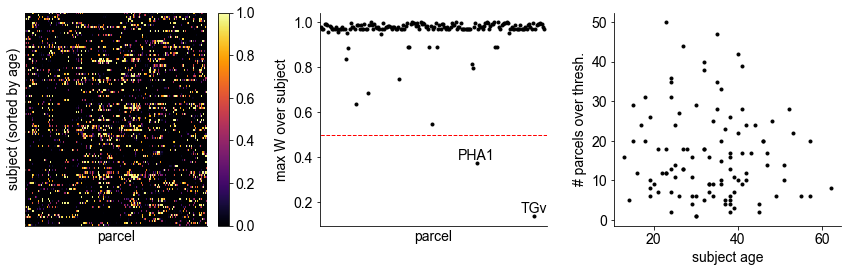

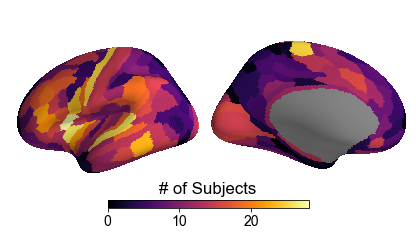

In [7]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'
if plot_subj_coverage:
    # plot aggregate max
    echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate')

    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i'%int(s_i))

# --------
# visualization of thresholded coverage 
plt.figure(figsize=(12,4))

# heat map of weight matrix max (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('parcel');plt.ylabel('subject (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# global maximum weight at each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('parcel');plt.ylabel('max W over subject')
plt.xticks([]); despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='bottom', horizontalalignment='center')


# of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], df_patient['coverage'],'.k')
plt.xlabel('subject age');plt.ylabel('# parcels over thresh.')
despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mni_mmp_coverage')

# number of patients that had coverage at each parcel
parcel_cvg = (df_W_max>=w_thres).sum(axis=0)
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(parcel_cvg, save_file=fig_path%'mmp_coverage', bp=0, title='# of Subjects');

We see that coverage is quite sparse and idiosyncratic across patients (data matrix in first column). The full data matrix is around 10% populated, but pooling across subjects, most parcels have at least one patient with an electrode very close to it (weight value of >0.9). PHA1 and TGv are the only parcels that do not meet the threshold in even a single patient. The best coverage are in sensorimotor, temporal, and frontal regions (which makes sense for epilepsy localization). Temporal-occipital-parietal junction areas are also not bad, and visual regions are surprisingly well covered.

Also, a few subjects between 25-40 years old have coverages that are much more than normal (>30 parcels), but overall there isn't a huge difference in coverage location (first column of top figure) nor total coverage (third column) across age, which is important to check for the age analysis later on.

---
# Relating Neuronal Timescale Gradient to Structural Gradients
In the next set of analyses, we look at the parcel-wise correlation between grand average timescale, and anatomical & gene expression heirarchy.

colormap sequential: [1.00e+01, 3.00e+01, 5.00e+01] (opaque)
colormap sequential: [1.00e+00, 1.35e+00, 1.70e+00] (opaque)


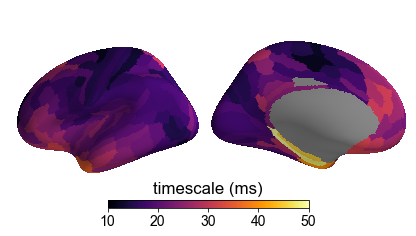

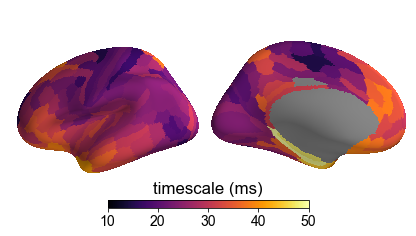

In [8]:
# plot grand average timescale on MMP
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['tau'], save_file=fig_path%'mmp_tau', minmax=[10,50], bp=0, title='timescale (ms)')

# plot log-spacing for more obvious contrast

#### NOTE THAT THE TICKS ARE NOT CORRECTLY SPACED IN THE SECOND PLOT ###
# ONLY 10 and 50 ARE IN THE RIGHT PLACE ####
## THIS IS CORRECTED POST-PRODUCTION ##

plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['logtau'], bp=0, minmax=[1,np.log10(50)], title='timescale (ms)')
plt.clim([10, 50])
plt.savefig(fig_path%'mmp_tau_log', bbox_inches='tight')

### Human Neuronal Timescale Has Rostrocaudal Spatial Gradient
The above visualizes the spatial gradient of human cortical timescales projected onto HCP-MMP. Qualitatively, we see that timescale are shorter (faster) in sensory regions (sensorimotor, visual), while frontal (especial medial frontal) and medial temporal/hippocampal regions have longer timescales. (Note that the second graph has log-spaced values, but the colorbar is incorrect here.)

This is consistent with reports in previous literature, where population timescales increase from sensory to association regions, but for the first time shown here for fast-timescale (synaptic and transmembrane current fluctuation) dynamics across the whole human brain.

---
# Timescale vs. T1w/T2w Ratio (Anatomic Hierarchy)

colormap sequential: [-2.50e+00, 0.00e+00, 2.50e+00] (opaque)


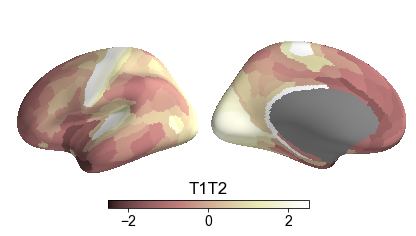

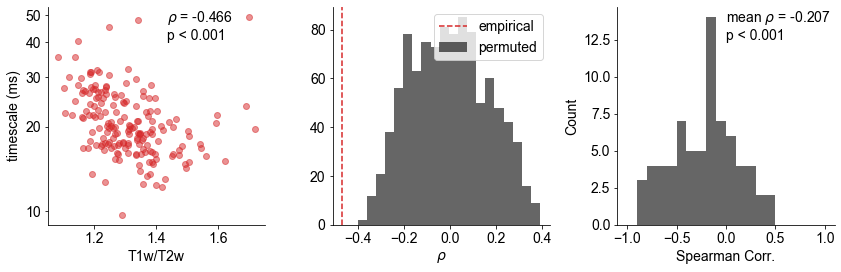

In [514]:
# per-subject correlation
min_parcels = 10

struct_feat = 'T1T2'
x = df_struct[struct_feat].values
y = df_tau['tau']

# plot feature on MMP brain
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(zscore(x), save_file=fig_path%('mmp_'+struct_feat), minmax=[-2.5,2.5], bp=0, title=struct_feat, cmap='pink')

# group average correlation
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(x, y, 'o', color=C_ORD[3], alpha=0.5); plt.yscale('log');
plt.xlabel('T1w/T2w'); 
plt.ylabel('timescale (ms)'); despine()
plt.yticks(np.arange(10,60, 10), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
s = echo_utils.sig_str(rho, pv_perm, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

plt.subplot(1,3,2)
plt.hist(rho_null, 20, color='k', alpha=0.6, label='permuted');
plt.axvline(rho, color=C_ORD[3], ls='--', label='empirical')
plt.legend()
#plt.title('resampled correlations')
plt.xlabel(r'$\rho$')

# per-subject correlation
df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = spearmanr(x, subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)
tt_pv = ttest_1samp(corr_valid, 0)[1]

plt.subplot(1,3,3)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = echo_utils.sig_str(np.nanmean(corr_valid), tt_pv, form='text', corr_letter=r'mean $\rho$')
plt.annotate(s, xy=(0.50, 0.85), xycoords='axes fraction')

plt.tight_layout();
plt.savefig(fig_path%('mmp_tau_%s_%i'%(struct_feat,d_query)), bbox_inches='tight')

T1w/T2w ratio is a measure of gray matter myelination, and has been shown to be higher in sensory regions (converging long-range connections) than association regions (local recurrent connections).

Overall, ECoG timescale is significantly and negatively correlated with T1w/T2w. This is true on average and at the individual subject level (only subjects with at least min_parcel number of parcels are included). This means areas with higher T1w/T2w values (higher myelination) have shorter timescales, again suggesting shorter timescale dynamics in primary sensory regions. There are exceptions, however, such as the lone dot in the top right corner, and the neighborhood of datapoints to the middle right (high T1w/T2w, intermediate timescale).

We can also look at this correlation within each subject. Since coverage varies between patients, we set a threshold where a subject is included only if they have at least n number of parcels (10 here). Again, correlations are significantly negative (2-sided 1-sample t-test) but with exceptions.

__In summary, fast synaptic fluctuation timescales measured via human ECoG is significantly correlated with, and may index, anatomical hierarchy, which itself is an index of feedforward vs. recurrent dominant architecture.__

---
# Timescale vs. Gene Expression
Next, we look at how the gradient of neuronal timescale matches gene expression gradients. Previous work has already demonstrated a relationship between T1w/T2w ratio and gene expression across the human cortex, so we should expect a relationship between timescale and overall gene expression gradient as well. To do this, we compute gene expression gradients using PCA and examine its relationship with neuronal timescale.

colormap sequential: [-2.50e+00, 0.00e+00, 2.50e+00] (opaque)


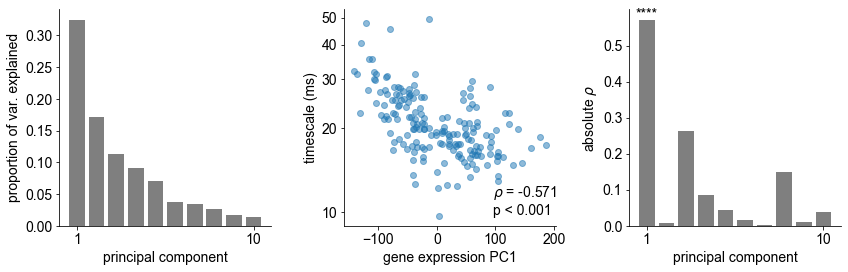

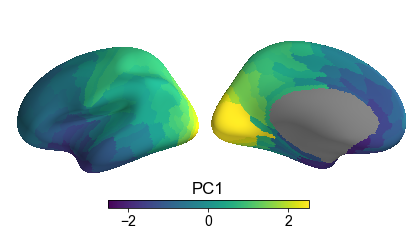

In [515]:
# perform PCA on all genes
n_pcs = 10
gene_pca = PCA(n_pcs)
#gene_pca.fit(df_genes.values)
gene_grad = gene_pca.fit_transform(df_genes.values)
df_pc_weights = pd.DataFrame(gene_pca.components_.T, index=df_genes.columns, columns=['pc%i'%i for i in range(1, n_pcs+1)])

x = gene_grad[:,0]
y = df_tau['tau']
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(range(1,n_pcs+1), gene_pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('principal component'); plt.ylabel('proportion of var. explained'); despine();

plt.subplot(1,3,2)
plt.plot(x, y, 'o', color=C_ORD[0], alpha=0.5); plt.yscale('log')
plt.xlabel('gene expression PC1'); plt.ylabel('timescale (ms)'); despine()
plt.yticks(np.arange(10,60, 10), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(echo_utils.sig_str(rho, pv_perm, form='text'), xy=(0.7,0.05), xycoords='axes fraction');

plt.subplot(1,3,3)
all_pc_rhos = np.array([echo_utils.compute_perm_corr(x, y, msr_nulls)[:3] for x in gene_grad.T])

plt.bar(range(1,n_pcs+1), np.abs(all_pc_rhos[:,0]), fc='k', alpha=0.5)
for i in range(1,11):    
    plt.annotate('*'*sum(all_pc_rhos[i-1,2]<[0.05, 0.01, 0.005, 0.001]), (i, abs(all_pc_rhos[i-1,0])+0.005), horizontalalignment='center')
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('principal component'); plt.ylabel(r'absolute $\rho$'); despine();

plt.tight_layout();
plt.savefig(fig_path%('mmp_tau_genePC1_%i'%d_query), bbox_inches='tight')

# plot PC1 on brain
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(zscore(x), save_file=fig_path%'mmp_gene_PC1', bp=0, minmax=[-2.5,2.5], title='PC1', cmap='viridis')
# plot all gene PCs on MMP brain
# for i_pc in range(1,5):
#     plt.figure(figsize=(6,6))
#     echo_utils.plot_MMP(gene_grad[:,i_pc], save_file=fig_path%('mmp_gene_PC'+str(i_pc+1)), bp=0, title='PC%i'%(i_pc+1), cmap='viridis')

### Neuronal timescale is associated with dominant gene expression gradient
We look at gene expression gradient across the cortex altogether via PCA, and compare that with neuronal timescale. The full list of genes can be found in the data table in ../df_structural.csv, which contains all genes from the Allen Brain Human Transcriptomics dataset. We can see above that timescale is significantly correlated with the dominant gene expression gradient (1st principal component), even more so than with anatomical hierarchy, but not the others remaining PCs.

In [11]:
# save out these main features in one table
pd.DataFrame(
    np.hstack((df_tau.values, df_struct['T1T2'].values[:,None], gene_grad[:,0][:,None])),
    index = df_struct.index,
    columns=['tau', 'logtau', 'T1T2', 'gPC1']
).to_csv('../data/df_human_features.csv')

---
### Correlations with specific genes with known role in neuronal & synaptic time constant tuning
Extracellular voltage fluctuations measured via LFP and ECoG are predominantly caused by transmembrane currents, whose timescale depend both on the neuronal integration and synaptic time constants. Therefore, expression of proteins responsible for ionic transport, synaptic receptors, and other transmembrane current-related genes should have a much more direct relationship with transmembrane current timescale as measured through ECoG, as the amount of ion channels and receptors in a local population of neurons directly alter the timecourse of the synaptic current (e.g., NMDA), and therefore the membrane current fluctuations. We test this by computing individual timescale-gene correlations below.

In [12]:
# run correlation with all genes, with unadjusted p-values from spearman
# only compute the permuted p-values for the ones plotted, otherwise it takes way too long for all 18k genes
df_tau_gene_corrall = pd.DataFrame([spearmanr(g.values, y.values) for g_i, g in df_genes.iteritems()], columns=['rho','pv'], index=df_genes.columns)

0.4680473677171106
-0.6006461104766608
-0.6099365206745063
0.5082667160509069
-0.6150436741874749
0.4483265944422153


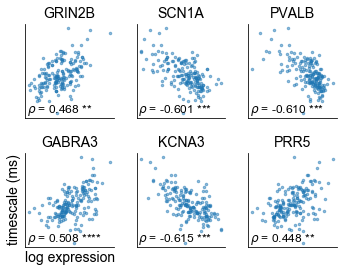

In [516]:
xlb = ['GRIN2B', 'SCN1A', 'PVALB', 'GABRA3', 'KCNA3', 'PRR5']

plt.figure(figsize=(5,4))
y = df_tau['tau']
xs = [df_struct[g] for g in xlb]

for i_x, x in enumerate(xs):
    plt.subplot(2,3,i_x+1)
    plt.plot(zscore(x), y, '.', color=C_ORD[0], alpha=0.5, ms=5); plt.yscale('log')
    plt.xticks([]); plt.yticks([])
    plt.tick_params('y', which='minor', left=False, labelleft=False)
    rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)
    plt.annotate(echo_utils.sig_str(rho, pv_perm, form='*'), xy=(0.02,0.05), xycoords='axes fraction', fontsize=12);
    print(rho)
    plt.title(xlb[i_x], fontsize=14)
    
plt.subplot(2,3,4)
plt.xlabel('log expression');plt.ylabel('timescale (ms)');
despine(); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_corrsingle', bbox_inches='tight')

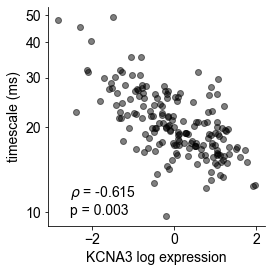

In [283]:
###### code snippet just to make a bigger pretty scatterplot 
plt.figure(figsize=(4,4))

query_gene = 'KCNA3'
x = df_struct[query_gene]
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)

plt.plot(x, y, 'o', color='k', alpha=0.5); plt.yscale('log')
plt.xlabel(query_gene+' log expression'); plt.ylabel('timescale (ms)'); 
plt.yticks(np.arange(10,60, 10), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(echo_utils.sig_str(rho, pv_perm, form='text'), xy=(0.1,0.05), xycoords='axes fraction');
plt.tight_layout(); despine()

### Query some gene families related to timescale

GRIN1
GABRA1
SCN1A
KCNA1
CORT
CELF6


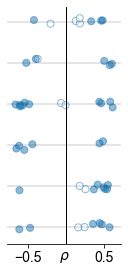

In [517]:
geneset_nmda = ['GRIN1', 'GRINA', 'GRIN2A','GRIN2B','GRIN2C','GRIN2D','GRIN3A', 'GRIN3B'] # nmda receptor
geneset_gabra = ['GABRA1','GABRA2','GABRA3','GABRA4','GABRA5','GABRA6'] # GABA-A alpha subchannels
geneset_sodium = ['SCN1A', 'SCN1B', 'SCN2A', 'SCN2B', 'SCN3A', 'SCN4A', 'SCN4B', 'SCN5A', 'SCN7A', 'SCN8A', 'SCN9A', 'SCN10A'] # sodium ion channels
geneset_potassium = ['KCNA1','KCNA2','KCNA3','KCNA4','KCNA5','KCNA6'] # GABA-A alpha subchannels
geneset_inh = ['CORT', 'CALB1', 'CALB2', 'SST', 'PVALB', 'CCK', 'NPY', 'PNOC', 'VIP'] # inhibitory markers
geneset_sctau = ['CELF6', 'PRR5', 'FAM81A', 'LRRC4C','OXTR', 'CTXN1', 'ENC1', 'AKAIN1'] # single-cell membrane time constant
gene_families = [geneset_nmda, geneset_gabra, geneset_sodium, geneset_potassium, geneset_inh, geneset_sctau]

# plot all correlations
plt.figure(figsize=(2,4))
plt.axvline(0, color='k', lw=1)
for i_g, gs in enumerate(gene_families):
    print(gs[0])
    set_x = df_tau_gene_corrall.loc[gs]['rho']
    set_y = np.random.randn(len(gs))/15+(5-i_g)

    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in [echo_utils.compute_perm_corr(df_genes[g].values, df_tau['logtau'].values, msr_nulls)[2] for g in gs]]
    plt.axhline(5-i_g, lw=0.2, color='k')
    plt.scatter(set_x, set_y, alpha=0.5, s=50, ec = C_ORD[0], c = set_color)
    

plt.xlabel(r'$\rho$', labelpad=-15)
plt.yticks([]); plt.xticks([-0.5, 0.5]);

despine(left=True); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_corrfamily', bbox_inches='tight')

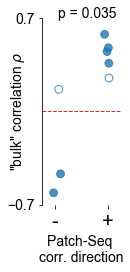

In [518]:
# time constant gene directions
sc_corr_dir = [1,1,-1,-1,1,1,1,-1]
agreement = np.sign(df_tau_gene_corrall.loc[geneset_sctau]['rho'].values)*sc_corr_dir
p_binom = binom_test((agreement>0).sum(), len(agreement), alternative='greater')
set_x = np.random.randn(len(gs))/10+np.array(sc_corr_dir)
set_color = [C_ORD[0] if p<0.05 else 'w' for p in [echo_utils.compute_perm_corr(df_genes[g].values, df_tau['logtau'].values, msr_nulls)[2] for g in geneset_sctau]]

plt.figure(figsize=(2,4))
plt.scatter(set_x, df_tau_gene_corrall.loc[geneset_sctau]['rho'].values, alpha=0.8, s=60, ec = C_ORD[0], c = set_color)
plt.axhline(0, color=C_ORD[3], ls='--', lw=1)
plt.annotate('p = %.3f'%p_binom, xy=(0.2,1), xycoords='axes fraction');
plt.xlim([-1.5,1.5]); plt.xticks([-1,1], ['-', '+'],fontsize=20); plt.xlabel('Patch-Seq \ncorr. direction')
plt.yticks([-0.7,0.7]); plt.ylabel(r'"bulk" correlation $\rho$', labelpad=-20)

despine(bottom=True); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_singlecell_bomkamp', bbox_inches='tight')

---
# Gene ontology enrichment analysis
PLS does multivariate decomposition

GOATOOLS to identify enriched categories

For a clear primer: https://link.springer.com/protocol/10.1007%2F978-1-4939-3743-1_13

In [15]:
# fit PLS model to empirical maps
pls = PLSRegression(n_components=1)
X = df_genes.values
Y = df_tau['logtau'].values
pls.fit(X, Y)
pls_coefs_emp = pls.coef_.squeeze()

# fit PLS to surrogate maps to get null distribution
pls_coefs_nulls = np.zeros((msr_nulls.shape[0], len(pls_coefs_emp)))
for i_y, Y in enumerate(msr_nulls):
    pls.fit(X, msr_nulls[i_y,:])
    pls_coefs_nulls[i_y,:] = pls.coef_.squeeze()
    
# find permuted p-values
pv_pls_coefs = 1-(abs(pls_coefs_emp)>abs(pls_coefs_nulls)).sum(0)/msr_nulls.shape[0]

# make df of genes and their PLS weights & pvalues
df_pls = pd.DataFrame(np.vstack((pls_coefs_emp, zscore(pls_coefs_emp), pv_pls_coefs)).T, columns=['w', 'w_zscore', 'pv'], index=df_genes.columns)

plt.figure(figsize=(4,4))
plt.plot(df_pls['w_zscore'], df_tau_gene_corrall['rho'], '.k', alpha=0.1, ms=1)
plt.xlabel('z-scored PLS weights');plt.ylabel(r'Spearman $\rho$');
plt.tight_layout(); despine()


### Run GOEA analysis with PLS-significant genes

In [142]:
alpha=0.05
# run enrichment analysis
enriched_genes = df_pls[(df_pls['pv']<alpha)].index.tolist()
enriched_ids = echo_utils.find_gene_ids(enriched_genes, symbol2id_dict)
goea_all = goea_obj.run_study(enriched_ids)

# print out significant GO terms
# in the enrichment column, e stands for enriched, p stands for purified (or lack of genes from that category)

#goea_results_sig[0].get_prtflds_all()
goea_results_sig = [r for r in goea_all if r.p_fdr_bh < 0.05]
# print relevant info from significant
df_goea=pd.DataFrame([[go.GO, go.enrichment, go.NS, go.depth, go.name, go.study_count, go.pop_count, go.ratio_in_study[0]/go.ratio_in_study[1], go.p_fdr_bh] for go in goea_all],
                    columns = ['ID', 'enrichment', 'branch', 'depth', 'name', 'n_enriched', 'n_in_cat', 'ratio_in_study', 'pv'])
df_goea_sig = df_goea[df_goea['pv']<0.05]
df_goea_sig

TypeError: run_study() got an unexpected keyword argument 'verbose'

In [78]:
df_gores = echo_utils.run_goea(df_pls, symbol2id_dict, posneg='neg')
# just splitting into 2 lines otherwise it gets unsightly
df_goea, df_goea_sig, goea_results, enriched_genes = df_gores
df_goea_sig

NameError: name 'run_goea' is not defined

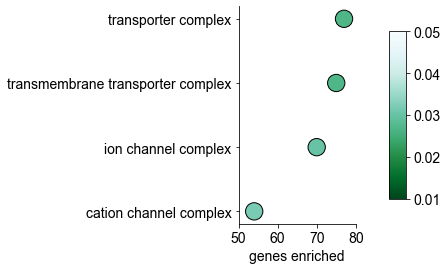

In [203]:
n_go = 4
plt.figure(figsize=(3,4))
plt.scatter(df_goea_sig.iloc[:n_go]['n_enriched'], np.arange(n_go)[::-1], s=300, marker='o', ec='k', c=df_goea_sig.iloc[:n_go]['pv'], cmap='BuGn_r')
plt.clim([0.01,0.05])
plt.yticks(range(n_go),df_goea_sig.iloc[:n_go]['name'][::-1])
plt.xlim([50,80]); plt.xlabel('genes enriched'); plt.xticks([50, 60, 70,80])
plt.colorbar(fraction=0.1, pad=0.2, shrink=0.8, aspect=10)
despine()
plt.savefig(fig_path[:-4]%'GOEA_names', bbox_inches='tight')

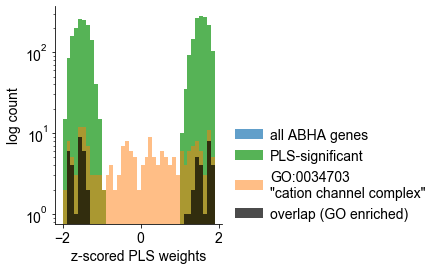

In [417]:
goea_plot = goea_results_sig[3]
id2symbol_dict = {v:k for k,v in symbol2id_dict.items()}
bins = np.arange(-2,2,0.1)
plt.figure(figsize=(3,4))
plt.bar(0,0, alpha=0.7)
plt.hist(df_pls[df_pls['pv']<alpha]['w_zscore'].values, bins, color=C_ORD[2], alpha=0.8, density=False);
plt.hist(df_pls.loc[[id2symbol_dict[gid] for gid in goea_plot.pop_items]]['w_zscore'].values, bins, color=C_ORD[1], alpha=0.5, density=False);
plt.hist(df_pls.loc[[id2symbol_dict[gid] for gid in goea_plot.study_items]]['w_zscore'].values, bins, color='k', alpha=0.7, density=False);
plt.xlabel('z-scored PLS weights');plt.ylabel('log count')
plt.yticks([]); plt.yscale('log')
despine()
plt.legend(['all ABHA genes', 'PLS-significant', 'GO:0034703\n\"cation channel complex\"', 'overlap (GO enriched)'], bbox_to_anchor= (1, 0.5), ncol=1, frameon=False, handletextpad=0.5)
plt.savefig(fig_path[:-4]%'GOEA_dist', bbox_inches='tight')

# Regressing out anatomical gradient & fit PLS model

In [53]:
### ----- REGRESS OUT T1/T2 from timescale and gene
# regress out T1T2 from timescale features
x = df_struct['T1T2'].values
df_tau_rmvt1t2, _ = echo_utils.get_residuals(x, df_tau)

# remove T1/T2 contribution from all genes by regressing out and get gene residuals
df_genes_rmvt1t2, genes_t1t2_coeffs = echo_utils.get_residuals(x, df_genes)

# compute timescale-gene residual correlations
y = df_tau_rmvt1t2['logtau']
df_tau_gene_corrall_rmvt1t2 = pd.DataFrame([spearmanr(g.values, y.values) for g_i, g in df_genes_rmvt1t2.iteritems()], columns=['rho','pv'], index=df_genes.columns)

colormap sequential: [9.87e-01, 1.34e+00, 1.69e+00] (opaque)
colormap sequential: [-3.31e-01, 8.87e-02, 5.09e-01] (opaque)


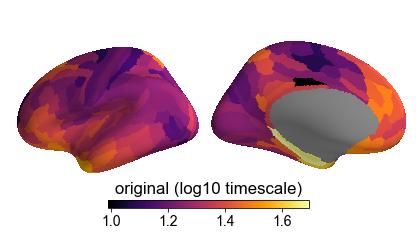

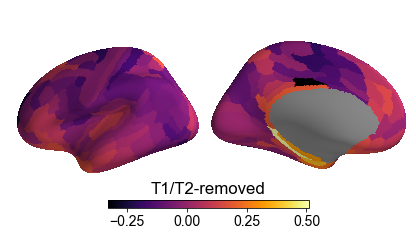

In [427]:
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['logtau'], bp=0, title='original (log10 timescale)', cmap='inferno')

plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau_rmvt1t2['logtau'], bp=0, title='T1/T2-removed', cmap='inferno')

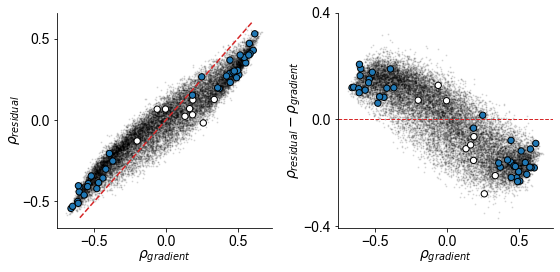

In [519]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_tau_gene_corrall['rho'], df_tau_gene_corrall_rmvt1t2['rho'], 'k.', ms=2, alpha=0.1)
plt.plot([-0.6, 0.6],[-0.6, 0.6], '--', color=C_ORD[3])
for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrall_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall.loc[gs]['rho'], df_tau_gene_corrall_rmvt1t2.loc[gs]['rho'], alpha=1, s=40, ec='k', fc=set_color, zorder=10)

plt.xticks([-0.5,0,0.5]);plt.yticks([-0.5,0,0.5])
plt.xlabel(r'$\rho_{gradient }$', labelpad=0);plt.ylabel(r'$\rho_{residual}$',labelpad=0)

plt.subplot(1,2,2)
plt.plot(df_tau_gene_corrall['rho'], df_tau_gene_corrall_rmvt1t2['rho']-df_tau_gene_corrall['rho'], 'k.', ms=2, alpha=0.1)

for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrall_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall.loc[gs]['rho'], df_tau_gene_corrall_rmvt1t2.loc[gs]['rho']-df_tau_gene_corrall.loc[gs]['rho'], alpha=1, s=40, ec='k', fc=set_color, zorder=10)
    
plt.xticks([-0.5,0,0.5]);plt.yticks([-0.4,0,0.4])
plt.axhline(0, ls='--', c=C_ORD[3], lw=1)
plt.xlabel(r'$\rho_{gradient}$',labelpad=0);plt.ylabel(r'$\rho_{residual} - \rho_{gradient}$', labelpad=0)
despine(); plt.tight_layout()

plt.savefig(fig_path%'tau_gene_rmvt1t2_corrchange', bbox_inches='tight')

In [ ]:
# fit PLS to timescale & gene residual
pls = PLSRegression(n_components=1)
X = df_genes_rmvt1t2.values
Y = df_tau_rmvt1t2['logtau'].values
pls.fit(X, Y)
pls_coefs_emp_rmvt1t2 = pls.coef_.squeeze()

# make new surrogate maps for the T1T2-removed tau maps and
msr_nulls_rmvt1t2 = ts_msr.randomize(df_tau_rmvt1t2['logtau'].values)

# fit PLS to surrogate maps to get null distribution
pls_coefs_nulls_rmvt1t2 = np.zeros((msr_nulls_rmvt1t2.shape[0], len(pls_coefs_emp_rmvt1t2)))
for i_y, Y in enumerate(msr_nulls_rmvt1t2):
    pls.fit(X, Y)
    pls_coefs_nulls_rmvt1t2[i_y,:] = pls.coef_.squeeze()
    
# find permuted p-values
pv_pls_coefs_rmvt1t2 = 1-(abs(pls_coefs_emp_rmvt1t2)>abs(pls_coefs_nulls_rmvt1t2)).sum(0)/msr_nulls_rmvt1t2.shape[0]

# make df of genes and their PLS weights & pvalues
df_pls_rmvt1t2 = pd.DataFrame(
    np.vstack((pls_coefs_emp_rmvt1t2, zscore(pls_coefs_emp_rmvt1t2), pv_pls_coefs_rmvt1t2)).T, 
    columns=['w', 'w_zscore', 'pv'], 
    index=df_genes.columns)


# plt.figure(figsize=(4,4))
# plt.plot(pls_coefs_emp,pls_coefs_emp_rmvt1t2, 'k.', ms=1, alpha=0.1)
# plt.plot(np.array([-2,2])*1e-5, np.array([-2,2])*1e-5, 'r--')
# plt.xlabel('original PLS weight'); plt.ylabel('T1T2-removed PLS weight');
# plt.xticks([0]);plt.yticks([0]);
# plt.tight_layout(); despine()

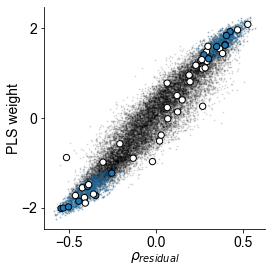

In [520]:
plt.figure(figsize=(4,4))
plt.plot(df_tau_gene_corrall_rmvt1t2['rho'], df_pls_rmvt1t2['w_zscore'], 'k.', alpha=0.1, ms=2)
plt.plot(df_tau_gene_corrall_rmvt1t2[df_pls_rmvt1t2['pv']<0.05]['rho'], df_pls_rmvt1t2[df_pls_rmvt1t2['pv']<0.05]['w_zscore'], '.', color=C_ORD[0], alpha=0.2, ms=2)

for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_pls_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall_rmvt1t2.loc[gs]['rho'], df_pls_rmvt1t2['w_zscore'].loc[gs], alpha=1, s=40, ec='k', fc=set_color, zorder=10)
    
plt.xticks([-0.5,0,0.5]);plt.yticks([-2,0,2])
plt.xlabel(r'$\rho_{residual}$',labelpad=0);plt.ylabel(r'PLS weight', labelpad=0)
despine(); plt.tight_layout()

plt.savefig(fig_path%'tau_gene_rmvt1t2_corrPLS', bbox_inches='tight')

In [20]:
# check that Pearson correlations are now zero between all genes and T1T2
df_genet1t2rmv_corrall = pd.DataFrame(
    [pearsonr(g.values, df_struct['T1T2'].values) for g_i, g in df_genes_rmvt1t2.iteritems()], 
    columns=['rho','pv'], index=df_genes.columns)

NameError: name 'df_pls' is not defined

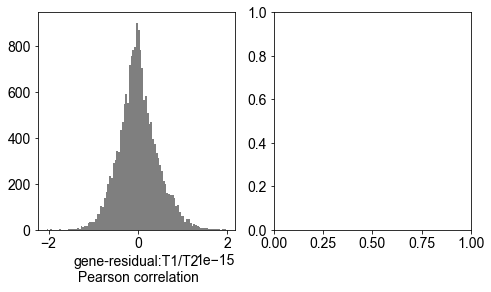

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(df_genet1t2rmv_corrall['rho'].values, 100, color='k', alpha=0.5)
plt.xlabel('gene-residual:T1/T2\n Pearson correlation')

plt.subplot(1,3,2)
plt.plot(df_pls['w'], df_pls_rmvt1t2['w'], 'k.', ms=1, alpha=0.1)
plt.plot(np.array([-2,2])*1e-5, np.array([-2,2])*1e-5, 'r--')
plt.xlabel('original PLS weight'); plt.ylabel('T1T2-residual PLS weight');
plt.xticks([0]);plt.yticks([0]);

plt.subplot(1,3,3)
plt.hist(np.log10(df_pls_rmvt1t2['pv'].values/df_pls['pv'].values), bins=np.arange(-2,2,0.02), color='k', alpha=0.5)
plt.xlabel('log(residual:original) p-value ratio')
plt.axvline(0, color='r')
plt.tight_layout(); despine()


In [522]:
df_gores_rmvt1t2 = echo_utils.run_goea(df_pls_rmvt1t2, symbol2id_dict, goea_obj, posneg='all')

# just splitting into 2 lines otherwise it gets unsightly
df_goea_rmvt1t2, df_goea_sig_rmvt1t2, goea_results_sig_rmvt1t2, enriched_genes_rmvt1t2 = df_gores_rmvt1t2
df_goea_sig_rmvt1t2


Run BP Gene Ontology Analysis: current study set of 1937 IDs ...
 84%  1,623 of  1,937 study items found in association
100%  1,937 of  1,937 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   8,102 GO terms are associated with  1,623 of  1,937 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1937 IDs ...
 89%  1,718 of  1,937 study items found in association
100%  1,937 of  1,937 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
   1,066 GO terms are associated with  1,718

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
15226,GO:0034702,e,CC,4,ion channel complex,55,282,0.028394,0.008270
15227,GO:1990351,e,CC,2,transporter complex,59,312,0.030459,0.008270
15228,GO:1902495,e,CC,3,transmembrane transporter complex,58,304,0.029943,0.008270
15229,GO:0034703,e,CC,5,cation channel complex,43,207,0.022199,0.009664
15230,GO:0098982,e,CC,4,GABA-ergic synapse,19,71,0.009809,0.045944
15231,GO:1902711,e,CC,4,GABA-A receptor complex,7,13,0.003614,0.048418


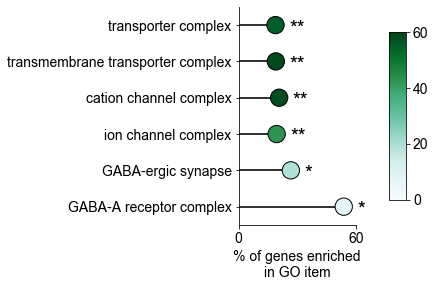

In [523]:
n_go = 6
plot_order = [1,2,3,0,4,5]

plt.figure(figsize=(3,4))    
plt.barh(n_go-np.arange(n_go), df_goea_sig_rmvt1t2.iloc[plot_order]['n_enriched']/df_goea_sig_rmvt1t2.iloc[plot_order]['n_in_cat'], height=0.05, color='k', alpha=0.8)
plt.scatter(df_goea_sig_rmvt1t2.iloc[plot_order]['n_enriched']/df_goea_sig_rmvt1t2.iloc[plot_order]['n_in_cat'], n_go-np.arange(n_go), s=300, marker='o', ec='k', c=df_goea_sig_rmvt1t2.iloc[:n_go]['n_enriched'], cmap='BuGn', zorder=10)
plt.clim([0, 60])
plt.yticks(range(1,n_go+1),df_goea_sig_rmvt1t2.iloc[plot_order]['name'][::-1], fontsize=14)
plt.xlabel('% of genes enriched\nin GO item');
plt.xticks([0, 0.6], ['0', '60'])
plt.colorbar(fraction=0.1, pad=0.2, shrink=0.8, aspect=10)

# wow.
for i_go, (_, go) in enumerate(df_goea_sig_rmvt1t2.iloc[plot_order].iterrows()):
    plt.text(go['n_enriched']/go['n_in_cat']+0.07, n_go-i_go-0.25, '*'*sum(go['pv']<np.array([0.05, 0.01, 0.005, 0.001])), fontsize=20)
    
despine()
plt.tight_layout()
plt.savefig(fig_path%'GOEA_res_rmvt1t2', bbox_inches='tight')


In [513]:
df_gores_rmvt1t2 = echo_utils.run_goea(df_pls_rmvt1t2, symbol2id_dict, goea_obj, posneg='neg')

# just splitting into 2 lines otherwise it gets unsightly
df_goea_rmvt1t2, df_goea_sig_rmvt1t2, goea_results_sig_rmvt1t2, enriched_genes_rmvt1t2 = df_gores_rmvt1t2
df_goea_sig_rmvt1t2


Run BP Gene Ontology Analysis: current study set of 1117 IDs ...
 86%    960 of  1,117 study items found in association
100%  1,117 of  1,117 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   6,299 GO terms are associated with    960 of  1,117 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1117 IDs ...
 89%    995 of  1,117 study items found in association
100%  1,117 of  1,117 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     857 GO terms are associated with    995

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
0,GO:0006813,e,BP,7,potassium ion transport,28,155,0.025067,0.003853
1,GO:0071805,e,BP,8,potassium ion transmembrane transport,26,146,0.023277,0.006807
17145,GO:0022857,e,MF,2,transmembrane transporter activity,97,938,0.086840,0.001928
17146,GO:0015079,e,MF,7,potassium ion transmembrane transporter activity,26,148,0.023277,0.002663
17147,GO:0005215,e,MF,1,transporter activity,104,1059,0.093107,0.002826
17148,GO:0015075,e,MF,3,ion transmembrane transporter activity,81,781,0.072516,0.004104
17149,GO:0046873,e,MF,6,metal ion transmembrane transporter activity,49,401,0.043868,0.004104
17150,GO:0015318,e,MF,3,inorganic molecular entity transmembrane trans...,74,734,0.066249,0.016954
17151,GO:0022832,e,MF,6,voltage-gated channel activity,27,183,0.024172,0.016954
17152,GO:0005244,e,MF,7,voltage-gated ion channel activity,27,183,0.024172,0.016954


In [7]:
# compute correlation of timescale with individual genes
df_tau_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
for i_f, s_f in enumerate(df_struct.columns[1:]):
    # no resampling
    rho, pv = spearmanr(df_struct[s_f], tau_parcel.values, nan_policy='omit')    
    # resample, takes really long
    #rho, _, pv, _ = echo_utils.perm_spearman(df_struct[s_f], tau_parcel.values)
    df_tau_corr_all.loc[s_f] = rho, pv

0.571315987118944
857 18114


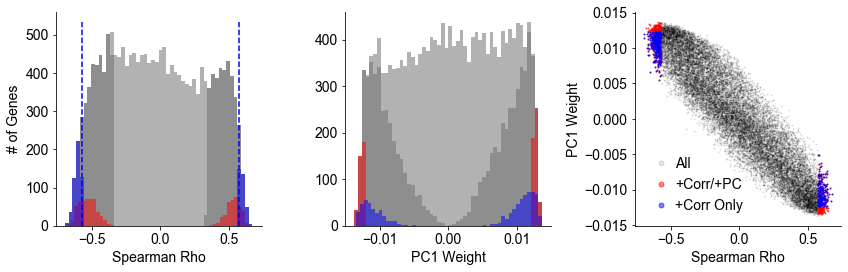

In [9]:
# threshold "high-correlation genes" by their correlation value, if they're greater than the timescale-PC1 correlation
rho_pc1 = np.abs(echo_utils.perm_spearman(gene_grad[:,0],tau_parcel.values, 1000, 'shuffle')[0])
print(rho_pc1)

# print out all the genes that are more correlated to timescale than overall expression gradient (PC1) for GeneOntology analysis
df_overexpr = df_tau_corr_all[np.abs(df_tau_corr_all['rho'])>rho_pc1].sort_values('rho')
print(len(df_overexpr), len(df_tau_corr_all))
echo_utils.print_gene_list(df_overexpr, 'go_over_correlated.txt')
echo_utils.print_gene_list(df_overexpr[df_overexpr['rho']>0], 'go_over_correlated_pos.txt')
echo_utils.print_gene_list(df_overexpr[df_overexpr['rho']<0], 'go_over_correlated_neg.txt')


# also print the same number of genes with the highest pc1 loadings
df_high_pc1 = np.abs(df_pc_weights).sort_values('pc1')[-len(df_overexpr):]
echo_utils.print_gene_list(df_high_pc1, 'go_high_pc1.txt')

# print genes that are in the high-correlation set but not in high pc1 loading set
diff_corr_pc1_genes = list(np.setdiff1d(df_overexpr.index.values, df_high_pc1.index.values))
echo_utils.print_gene_list(diff_corr_pc1_genes, 'go_diff_corr_pc1.txt')

plt.figure(figsize=(12,4))
# distribution of rho values over all genes
plt.subplot(1,3,1)
plt.hist(df_tau_corr_all['rho'], 50, color='k', alpha=0.3);
plt.hist(df_tau_corr_all[df_tau_corr_all['pv']<0.05/len(df_tau_corr_all)]['rho'], 50, color='k', alpha=0.2); # shade those surviving Bonferroni correction at p=0.05
YL = plt.ylim()
# mark rho value for timescale-genePC1
plt.plot([rho_pc1]*2, YL, 'b--'); plt.plot([-rho_pc1]*2, YL, 'b--');
plt.xlabel('Spearman Rho'); plt.ylabel('# of Genes')
subinds = df_tau_corr_all.index.isin(df_high_pc1.index)
plt.hist(df_tau_corr_all[subinds]['rho'], 50, fc='r', alpha=0.5)
subinds = df_tau_corr_all.index.isin(df_overexpr.index)
plt.hist(df_tau_corr_all[subinds]['rho'], 50, fc='b', alpha=0.5)
despine(); 

# distribution of PC1 weighting
plt.subplot(1,3,2)
plt.hist(df_pc_weights['pc1'], 50, fc='k', alpha=0.3)
plt.hist(df_pc_weights[df_tau_corr_all['pv']<0.05/len(df_tau_corr_all)]['pc1'], 50, color='k', alpha=0.2); # shade those surviving Bonferroni correction at p=0.05
subinds = df_tau_corr_all.index.isin(df_high_pc1.index)
plt.hist(df_pc_weights[subinds]['pc1'], 50, fc='r', alpha=0.5)
subinds = df_tau_corr_all.index.isin(df_overexpr.index)
plt.hist(df_pc_weights[subinds]['pc1'], 50, fc='b', alpha=0.5)
plt.xlabel('PC1 Weight');
despine()

# scatterplot of correlation magnitude against PC1 weight for all genes
plt.subplot(1,3,3)
plt.plot(df_tau_corr_all['rho'], df_pc_weights['pc1'], 'k.', alpha=0.1, ms=2)
subinds = df_tau_corr_all.index.isin(df_overexpr.index)
plt.plot(df_tau_corr_all[subinds]['rho'], df_pc_weights[subinds]['pc1'], 'r.', ms=2, alpha=0.5) 
subinds = df_tau_corr_all.index.isin(list(np.setdiff1d(df_overexpr.index.values, df_high_pc1.index.values)))
plt.plot(df_tau_corr_all[subinds]['rho'], df_pc_weights[subinds]['pc1'], 'b.', ms=2, alpha=0.5) 
plt.xlabel('Spearman Rho');plt.ylabel('PC1 Weight');despine()
plt.legend(['All', '+Corr/+PC', '+Corr Only'], markerscale=5, fancybox=False, frameon=False, handletextpad=0)

plt.tight_layout()

### Genes Highly Associated with Neuronal Timescale are Specific to Ion Transporters and Synaptic Reptors
In the above analysis, we find all genes that are more correlated (in absolute value) with timescale than PC1 is (~0.571), marked in blue (N=857 in total). That threshold is denoted by the blue dotted lines in the distribution of rho values in the first plot. These are genes that have a higher association with timescale than to be expected from the gene expression gradient alone. Those with significant correlations surviving Bonferroni correction are shaded darker. Many of these genes also happen to be highly loaded on PC1 (blue points in second histogram), i.e., they follow the generic rostrocaudal gradient of brain organization, though the sub-distributions are more normally distributed, implying a spread within the covariation. 

What we want to find is the list of genes that __are higly associated with timescale but not the generic structural gradient__, and flag them as timescale-specific genes. To do that, we find the same number of genes (top N=857) that are the most loaded along PC1 (colored red). From the high-correlation list of genes, we remove any genes that are also in the high-PC1-loading list, resulting in `diff_corr_pc1_genes`. The third plot shows all genes, and their timescale-correlation and PC1 loading. The red genes are excluded, resulting in all the blue genes that are more associated with timescale gradient than the generic transcriptomic gradient.

We submit that list for [GeneOntology analysis][GO], resulting in a list of molecular functions and cellular components that are more associated with this list of genes than by chance (compare to the whole list as reference). To do this, go to GeneOntology (follow the link) and submit `go_diff_corr_pc1.txt` as the analysis list, and `go_ref_list` as the reference list. 

Printed below are the list of molecular functions that are associated with the highly correlated genes than by chance, which include sodium and potassium transmembrane transporters, as well as voltage-gated potassium channel. Cellular component analysis results in similar answers. See images in `../data/img/GO_results` for list. Crucially, submitting the list of genes that have high PC1 loading does not result in overexpression of any specific functions related to transmembrane ionic transport. We can repeat this analysis with only genes that are more __positively__ correlated with timescale, also resulting in a list of cellular components highly associated with synaptic receptor and ion channel complexes (`GO_results/pos_GO_cellularcomp.png`).

__Overall, these data suggests that neuronal timescales are associated (potentially causally supported) by expression of genes associated with synaptic receptor and transmembrane ion transport, above and beyond the generic rostrocaudal gene expression gradient would imply.__

[GO]:http://pantherdb.org/tools/compareToRefList.jsp

https://www.genecards.org/Search/Keyword?queryString=%22membrane%20time%20constant%22

![](../data/img/GO_results/diff_GO_molecularfunc.png)

### Correlation with Specific Genes
Below, we plot some correlations with candidate genes associated with synaptic receptor and ion transport.
http://compneuro.uwaterloo.ca/research/constants-constraints/neurotransmitter-time-constants-pscs.html

In [10]:
# pick some families of genes for query
geneset_gluion = ['GRIK1','GRIK2','GRIK3','GRIK4','GRIK5','GRIA1','GRIA2','GRIA3','GRIA4'] # ionotropic glutamate
geneset_nmda = ['GRIN1', 'GRINA', 'GRIN2A','GRIN2B','GRIN2C','GRIN2D','GRIN3A', 'GRIN3B'] # nmda
geneset_gabra = ['GABRA1','GABRA2','GABRA3','GABRA4','GABRA5','GABRA6', 'PVALB', 'SST', 'CALB1'] # GABA-A alpha + inh
geneset_sodium = ['SCN1A', 'SCN1B', 'SCN2A', 'SCN2B', 'SCN3A', 'SCN4A', 'SCN4B', 'SCN5A', 'SCN7A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCNN1B', 'SCNN1D'] # sodium ion channels
geneset_inh = ['CORT', 'CALB1', 'CALB2', 'SST', 'PVALB', 'CCK', 'NPY', 'PNOC', 'VIP'] # inhibitory markers
geneset_sctau = ['LRRC4C','OXTR','CELF6', 'PRR5', 'FAM81A', 'CTXN1', 'ENC1', 'AKAIN1'] # single-cell membrane time constant

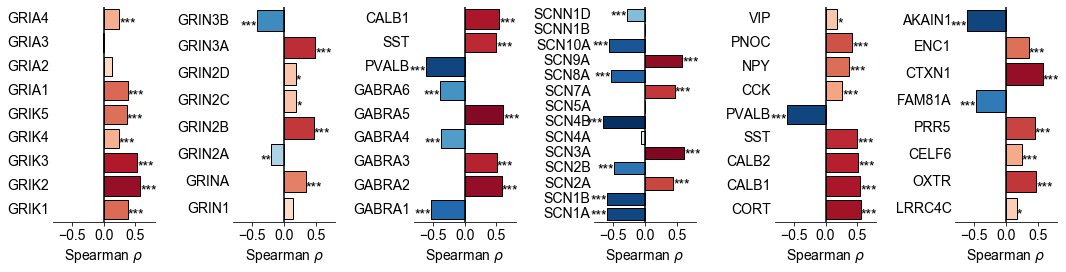

In [11]:
# plot families of correlations as hbar
color = plt.cm.RdBu_r(np.linspace(0,1,200))
plt.figure(figsize=(15,4))
plot_set = [geneset_gluion, geneset_nmda, geneset_gabra, geneset_sodium, geneset_inh, geneset_sctau]
for i_g, g_subset in enumerate(plot_set):
    plt.subplot(1,len(plot_set),i_g+1)
    geneset_plot = df_tau_corr_all.loc[g_subset]
    for i_p in range(len(geneset_plot)):
        rho, pv = geneset_plot.iloc[i_p]
        plt.barh(i_p, rho, ec='k', fc=color[int((1+rho*1.5)*100)])
        s = np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
        plt.text(rho, i_p-0.4, s, fontsize=14, horizontalalignment='left' if rho>0 else 'right')

    plt.plot([0,0], plt.ylim(), 'k')
    plt.ylim([-0.5,len(geneset_plot)-0.5])
    plt.yticks(range(len(geneset_plot)), geneset_plot.index.values, rotation=0, ha='right', va='center', rotation_mode='anchor', fontsize=14)
    plt.tick_params(axis='y', which=u'both',length=0)
    plt.xlim([-.8,.8]); plt.xlabel(r'Spearman $\rho$')
    despine(left=True);

plt.tight_layout()
plt.savefig(fig_path[:-4]%'mni_gene_indiv',  bbox_inches='tight')

A quick note on synaptic receptor and ion transporter complex __subunits__: synaptic receptors, for example, are composed of several subunits, and each subunit can have several isoforms that can be swapped in and out, modulating different aspects of synapse function. Differential expression of a particular isoform of a subunit can denote cell-type differences. For example, per [Wikipedia](https://en.wikipedia.org/wiki/GRIN2B): 

> "NMDA receptor channels are heterotetramers composed of two molecules of the key receptor subunit NMDAR1 (GRIN1) and two drawn from one or more of the four NMDAR2 subunits: NMDAR2A (GRIN2A), NMDAR2B (GRIN2B), NMDAR2C (GRIN2C), and NMDAR2D (GRIN2D)." 
---

From the plots above, we see that transmembrane current timescale is positively and strongly correlated with expression of kainate (GRIK), and less so with AMPA (GRIA) receptor subunits (first plot). AMPA receptors are the primary excitatory synapses everywhere in the brain and have very fast rise and decay time constants. Kainate receptors, on the other hand, have a slower time constant, and have metabotropic effects (secondary signaling cascade) in addition to its direct ionotropic effects. Correlation with NMDA subunits expression (second plot) is more variable: most strongly with GRIN2B, which has been shown to lengthen NMDA activation time constant and improve cognitive function in animals with engineered overexpression, and decrease in aging. In addition, neuronal timescales are also strongly correlated with the expression of various forms of GABA-A receptor alpha subunits (third plot), as well as sodium transporter complexes (fourth plot), and inhibitory cell type markers (fifth plot). Interestingly, timescale is strongly and negatively correlated with PV expression, and positively correlated with all other inhibitory celltype markers.

The final plot is noteable: these genes were found in a single-cell transcriptomic study as to be highly associated with single-cell membrane fluctuation timescale properties (GLIF-model fitted time constant, resistance, and capacitance, [Bomkamp et al., 2019][bomkamp2019]). Quite surprisingly, bulk expression of these genes are also correlated with mesoscale measures of transmembrane current timescale in the population (shown above, same directions as predicted from single-cells). __This suggests that the field potential signal is a relatively accurate surrogate signal to intracellular membrane potential fluctions.__

__In summary, transmembrane current fluctuation timescales are also strongly correlated with average gene expression of many synaptic receptor, transmembrane ion transport complex, and cell-type marker proteins, linking dynamics with its potential structural support. It also argues for the importance of these slower currents in accurately modeling the field potential/ECoG signal.__

[bomkamp2019]:https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007113

---

---
# Age-Related Changes in Timescale
In the second half of this notebook, we look at changes in neuronal timescale through aging.

---
The brain undergoes many changes structurally during early development, as well as in elderly populations. Many such changes are linked with specific cellular and synaptic parameters, such as loss of PV+ inhibitory neurons and GluN2B-containing NMDA receptors. Cognitively, older adults show impairments in higher-order functions, such as working memory and cognitive control. If neuronal dynamics is supported by structural properties, and ultimately enabling complex behaviors, we would also expect robust changes over time. In particular, we hypothesize that older adults would have __shorter neuronal timescales__, as they often exhibit a decreased ability to hold multiple objects in working memory, potentially caused by a shorter synaptic integration window or reduced recurrent activity, or both. We look at this in the same dataset, across subjects.

---

### Per-Subject Average Timescale

The ideal analysis here is mixed effects model to jointly estimate the effect of age and hierarchy (with T1T2 as an regressor, e.g.) on tau, but the overall coverage is very poor (10% of total subj x parcel matrix is non-empty) and different across subjects. So we'd have to perform a lot of imputation to fill out that data matrix.

That being the case, we can only look at the average effect across both space (hierarchy) and age, which will confound and/or diminish our estimate of both effects, if there are any. Averaging across subjects for the per-parcel timescale estimate is not too bad, since each parcel has a relatively large sampling of age ranges (see first panel of first figure), and we expect a rather large spatial effect in the first place. 

But averaging across parcels for the per-subject estimate is more strongly biased by the non-uniform coverage of each patient, such that the per-patient timescale estimate essentially comes from a handful of adjacent parcels. Therefore, we need to normalize each tau by the parcel average (or max) first before averaging across parcels to remove the spatial effect. Kinda janky, but best I can think of given the sparse sampling problem.

We set a threshold on how many parcels the subject needs to have to be included in this analysis in the first place. Doesn't have to be a large value, since each person usually only has 5-20% coverage (10-30 out of 180).

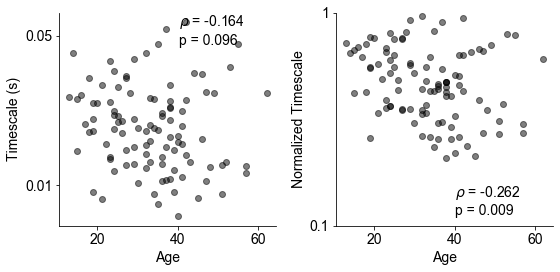

In [12]:
# FREE PARAMETER TO JIGGLE!
# threshold for including subjects if they have at least this many parcels
n_parcel_thresh = 3
# FREE PARAMETER TO JIGGLE!

plt.figure(figsize=(8,4))

# unnormalized averages over parcels per patient
tau_subj = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted', axis=1)
x = df_patient['age'][df_patient['coverage']>=n_parcel_thresh]
y = tau_subj[df_patient['coverage']>=n_parcel_thresh]
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,5000)

plt.subplot(1,2,1)
plt.semilogy(x, y, 'ok', alpha=0.5);
plt.xlabel('Age'); plt.ylabel('Timescale (s)'); despine()
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)

# normalized averages over parcels per patient
df_tau_threshed_parcelnorm = df_tau_threshed/df_tau_threshed.max()
tau_subj_normed = df_tau_threshed_parcelnorm.mean(axis=1)
y = tau_subj_normed[df_patient['coverage']>=n_parcel_thresh]
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')

plt.subplot(1,2,2)
plt.semilogy(x, y, 'ok', alpha=0.5)
plt.xlabel('Age'); plt.ylabel('Normalized Timescale'); despine()
plt.ylim([0.1, 1])
plt.yticks([0.1,1], ['0.1', '1']); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(s, xy=(0.55, 0.05), xycoords='axes fraction')

plt.tight_layout()
plt.savefig(fig_path%'mni_age_overall',  bbox_inches='tight')

### Neuronal Timescale Decreases with Age
The unnormalized per-patient average timescale decreases with age, but the effect is weak. As expected, the parcel-normalized average estimates a much larger effect in the negative correlation between timescale and age. This means that older adults on average have shorter intrinsic timescales as measured via ECoG. Previous reports have reported loss of NMDA receptors (subunit 2B, in particular) in older rats, potentially implicating that as a mechanism of shortened spontaneous dynamics.

### Region Specific Changes in Timescale
The above result shows overall decrease in ECoG timescale when adjusted for region, but is there spatial specificity to the negative correlation between timescale and age? Once again, since coverage is non-uniform across subjects, and is generally sparse and different for each individual region, we can compute a timescale-age correlation for each parcel, but each parcel will have different subjects' data. The following analysis also only includes parcels where there are at least n subjects have data (above the confidence threshold of 0.5).

colormap sequential: [-7.50e-01, 0.00e+00, 7.50e-01] (opaque)


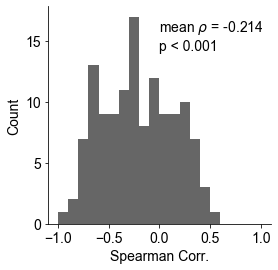

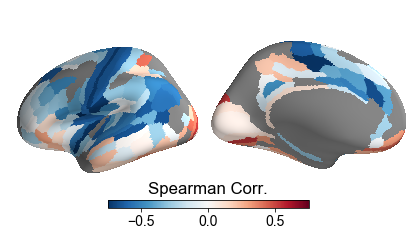

In [13]:
# FREE PARAMETER TO JIGGLE!
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 5
# FREE PARAMETER TO JIGGLE!

# for each parcel, record the number of subjects included, and the spearman rho and p-value
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        # hard threshold of having at least 3 subjects because correlation won't run otherwise
        rho, pv = spearmanr(df_patient['age'], col, nan_policy='omit')
    else:
        # otherwise just fill up with nans
        rho, pv = np.nan, np.nan
    df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
        
# only count correlations from parcels that had min # of subjs, set those that did not meet threshold to nan
parcel_corr = df_age_corr['rho'].astype(float)
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan
x = parcel_corr.values
# t-test on whether parcels have positive or negative correlation in aggregate
tt_pv = ttest_1samp(x, 0, nan_policy='omit')[1]

# plot
plt.figure(figsize=(4,4))
plt.hist(x, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = echo_utils.sig_str(np.nanmean(x), tt_pv, form='text', corr_letter=r'mean $\rho$')
plt.annotate(s, xy=(0.5, 0.8), xycoords='axes fraction')
#plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_dist_%i'%(d_query)), bbox_inches='tight')

# plot spatial distribution of correlation
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(x, fig_path%'mmp_parcel_agecorr', minmax=[-.75,.75], cmap='RdBu_r', title='Spearman Corr.', bp=0)

### Regional Differences in Age-Timescale Relationship
From the distribution, we see that across parcels, timescale is on average negatively correlated with age, which agrees with the subject-average analysis above. Looking across the cortex, sensorimotor and temporal regions have the largest negative correlations. 

Curiously, visual regions consistently have positively correlations, i.e., timescale increases with age. One potential explanation is the combination of the following: 1) visual regions have high numbers of PV+ interneurons, 2) older adults experience a selective loss of those interneurons, 3) PV expression is negatively correlated with timescale. Therefore, loss of PV+ interneurons would lead to longer timescales in visual cortex, though this is a just-so story. The key caveat/assumption here is that **expression in a region may not be correlated with its change in expression across aging.**

A similar case can be made for (loss of) NMDA synpases and frontal region decrease in timescale.

---
### Age-Tau Correlation vs. Gene Expression 
One way to check the above logic is to see if the correlation coefficient within a parcel is then correlated with the expression value of certain genes. Note that this is not quite the ideal thing we want: we would like to see if the age-related expression change of a __single gene__ is correlated with its overall expression at a single region. Assuming gene expression changes contributes to timescale changes (mechanistically, though we've only shown correlations), then we can use timescale as an index for __combined gene expression__. As in, the combined change in expression of many genes gives rise to a __single tau estimate__ at a region.

Nevertheless, we can ask: which genes' expression correlate with, not timescale itself, but the change in timescale across aging.

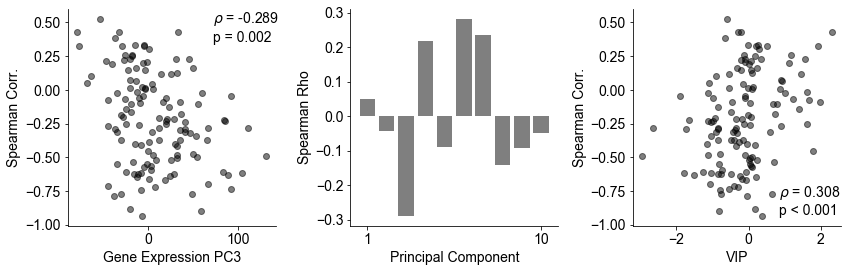

In [14]:
# gene expression vs. tau-age correlation within parcel
plt.figure(figsize=(12,4))

# age-timescale correlation vs. gene expression PCA
x = gene_grad[:,2]
y = parcel_corr.values
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')
plt.subplot(1,3,1)
plt.plot(x, y, 'ok', alpha=0.5)
plt.xlabel('Gene Expression PC3'); plt.ylabel('Spearman Corr.'); despine()
plt.annotate(s, xy=(0.7, 0.85), xycoords='axes fraction');

# correlation between PCs and age-tau correlation map
plt.subplot(1,3,2)
all_pc_rhos = np.array([echo_utils.perm_spearman(x, y, 1000, 'shuffle')[0] for x in gene_grad.T])
plt.bar(range(1,n_pcs+1), all_pc_rhos, fc='k', alpha=0.5)
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('Principal Component'); plt.ylabel('Spearman Rho'); despine();
plt.tight_layout()


# age-time scale correlation vs. a single gene
struct_feat = 'VIP'
x = df_struct[struct_feat].values
y = parcel_corr.values
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')

plt.subplot(1,3,3)
plt.plot(x, y, 'ok', alpha=0.5)
plt.xlabel(struct_feat); plt.ylabel('Spearman Corr.'); despine()
plt.annotate(s, xy=(0.7, 0.05), xycoords='axes fraction');

plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_meta_%i'%(d_query)), bbox_inches='tight')

### Age-Tau Correlation Does Not Follow Dominant Gene Expression Gradient
Unlike the timescale map across the brain, the correlation map between age and timescale does not follow the dominant gradient of gene expression (PC1), but are moderately correlated with several of the subsequent PCs. As such, we then find instead the highest correlated genes to the age-tau map.

In [15]:
# compute correlation of age-timescale-corr with individual genes
df_age_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
for i_f, s_f in enumerate(df_struct.columns[1:]):
    # no resampling
    rho, pv = spearmanr(df_struct[s_f], parcel_corr.values, nan_policy='omit')    
    # resample, takes really long
    #rho, _, pv, _ = echo_utils.perm_spearman(df_struct[s_f], parcel_corr.values)
    df_age_corr_all.loc[s_f] = rho, pv

In [16]:
echo_utils.print_gene_list(df_age_corr_all.sort_values('rho')[-500:], 'go_agetau_pos.txt')
echo_utils.print_gene_list(df_age_corr_all.sort_values('rho')[:500], 'go_agetau_neg.txt')

print(df_age_corr_all.sort_values('rho')['rho'][:30])
print(df_age_corr_all.sort_values('rho')['rho'][-30:])

CHI3L2     -0.574343
ENO3       -0.539942
LDLRAD3    -0.534875
LIPC       -0.530712
CD93       -0.530068
CCDC141    -0.508737
DTL        -0.502351
GZMH       -0.500929
HTR2B      -0.487516
GBP2       -0.485579
MMEL1      -0.485398
NAT1       -0.483424
MBOAT1     -0.483313
ZFP30      -0.482755
CSN3       -0.480926
SLC6A9     -0.480162
MRPL52     -0.478251
ANG        -0.476889
CASQ2      -0.474102
LAIR2      -0.473353
TBC1D10C   -0.470689
TLL2       -0.468451
PIK3CG     -0.467891
SRPX       -0.467819
PRR15       -0.46739
NANOG      -0.467087
SINHCAF     -0.46537
GPC3       -0.459287
PTPRM      -0.457467
MTCP1      -0.456775
Name: rho, dtype: object
PAPSS2       0.486686
ALG10B       0.490177
SRF          0.490431
AQP4-AS1     0.492303
OR10H3       0.493181
CENPV         0.49533
FBXL22        0.49781
COG3         0.498729
MLLT3        0.499387
SUMO4        0.499662
MTERF2       0.501933
KIF3B         0.50228
TMEM74B      0.502511
KIAA1211L    0.503107
GEN1         0.503261
CAMSAP3       0

Printing out the list of genes that are most correlated with the age-timescale association returns nothing obvious by eye, though it's interesting that GABBR2 (GABAB receptor subunit) has a very strong correlation. Submitting the 500 most and least correlated genes to GeneOntology results in no significant findings.

# Supplemental Goodies

---
# Pool into 21 Glasser Macro Regions
This section repeats the key analyses from above, but with the 22 macro regions found in Glasser et al., 2018 Supplemental, so we can visualize (label) to see if any regions stand out. V1 parcel had its own group so I lumped it with "early visual" (hence 21 regions). All parcels within a macro region are then averaged, both for timescale and structural measures.

In [17]:
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
for i_r, r in mmp_aggr.groupby('macro_labels'):
    df_tau_macro[i_r] = echo_utils.compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[r['parcel']].mean(axis=0)
    
df_struct_macro = df_struct_macro.T
df_tau_macro_mean = df_tau_macro.mean(0)

### Spatial Correlation with T1w/T2w and Gene Expression

In [ ]:
struct_feat = 'GRIN2B'
plt.figure(figsize=(8,8))
x = df_struct_macro[struct_feat]
y = df_tau_macro_mean

plt.plot(x,y, 'ok', alpha=0.5)
for mr in df_struct_macro.index:
    plt.annotate(mr, (df_struct_macro.loc[mr][struct_feat], df_tau_macro_mean[mr]), 
                 horizontalalignment='left', verticalalignment='bottom', fontsize=14)
    
plt.yscale('log'); 
plt.xlabel(struct_feat); plt.ylabel('Timescale (ms)');despine()
plt.yticks(np.arange(0.02,0.04, 0.01), (np.arange(0.02,0.04, 0.01)*1000).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)


spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')
rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.25, 0.85), xycoords='axes fraction');
plt.tight_layout()

Macro region correlations between timescale and structural variables are even stronger, exemplified by the above for GRIN2B (also try PV+). As expected, early sensory regions (visual, primary sensory/motor) have very short timescales, while association regions (medial temporal, frontal) have longer timescales. 

### Age Correlation per Region

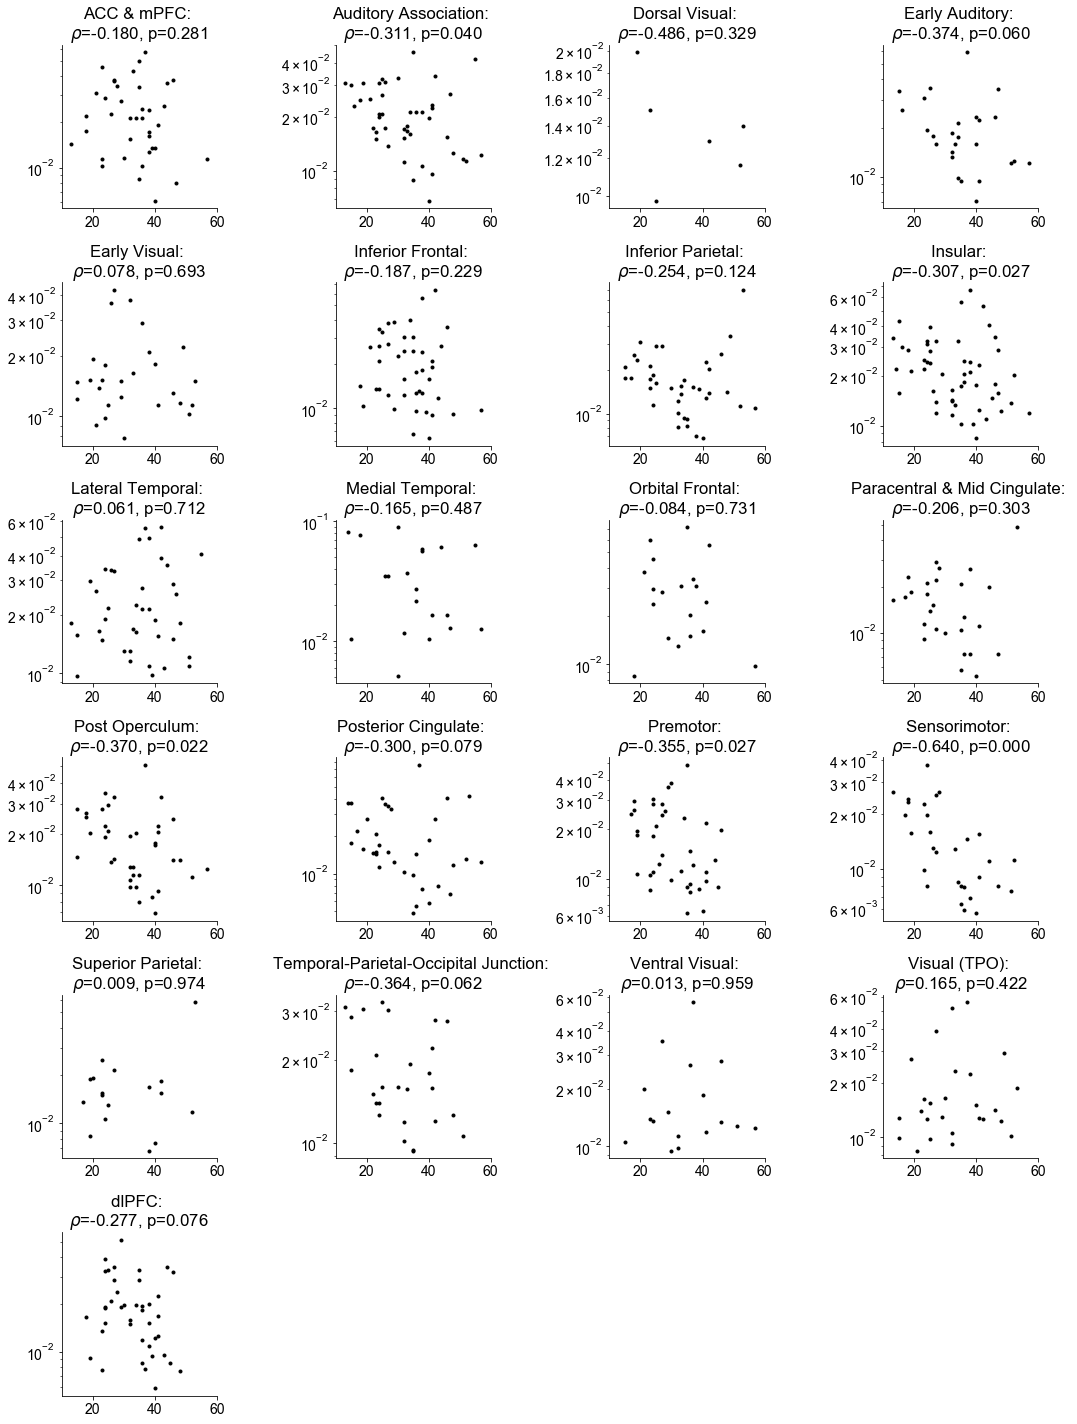

In [260]:
plt.figure(figsize=(15,20))
for i_r, r in enumerate(df_tau_macro.columns):
    plt.subplot(6,4,i_r+1)
    plt.semilogy(df_patient['age'], df_tau_macro[r], '.k')
    rho,pv = spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
    plt.tick_params(axis='y', which='both', left='off', labelleft='off')
#    plt.yscale('log')
#    plt.yticks([]);

    plt.xlim([10,60]); despine()
    
    plt.title('%s: \n'%r + r'$\rho$=%.3f, p=%.3f'%(rho,pv))

plt.tight_layout()

Again, timescale-age correlations are consistently negative, but differ in strength across areas. Sensorimotor and premotor have the strongest effects, while visual areas are again (slightly) positive.